<a href="https://colab.research.google.com/github/emm32449/MCTS-in-Python/blob/main/AddingGame_MCTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The game is a simple adding game. The game starts at 0 and players can make moves by adding 1, 2, or 3 to the current state. The goal is to reach exactly 10. If a player’s move results in a state exceeding 10, they receive a negative reward. If the state is less than 10, the reward is based on how close the state is to 10. The game resets once it reaches or exceeds 10.

In [ ]:
# Assume we have a simple game state
class GameState:
    def __init__(self, state):
        self.state = state

    def __str__(self):
        return str(self.state)

    def get_legal_moves(self):
        return [1, 2, 3]

    def get_initial_state(self):
        return GameState(0)

    def make_move(self, move):
        return GameState(self.state + move)

    def is_terminal(self):
        return self.state >= 10

    def get_reward(self):
        # Give a positive reward if the state is exactly 10
        if self.state == 10:
            return 1
        # Give a negative reward if the state exceeds 10
        elif self.state > 10:
            return -1
        # Give a reward based on how close the state is to 10
        else:
            return 1 - abs(self.state - 10) / 10

    def reset(self):
        self.state = 0

    def copy(self):
        return GameState(self.state)

    def to_array(self):
        return [self.state]


Alpha Go Zero uses a variant of Monte Carlo Tree Search (MCTS) within its training loop. Starting from the root node, which represents the current game state, it traverses the tree until it reaches a leaf node. This game state is passed through the neural network, which outputs a vector of move probabilities and a scalar estimating the expected outcome. The leaf node is then expanded, with each legal move becoming a new child node. The move probabilities output by the network initialize the prior probabilities of selecting each child node in future simulations. The estimated value output by the network is backpropagated up the tree, updating the value estimates of all nodes along the traversed path.

This process is repeated for many simulations, with the Upper Confidence Bound (UCB) formula guiding the selection of nodes during tree traversal. The UCB formula balances exploration and exploitation, taking into account both the value of the node and the prior probability of the node, as well as the number of times the node has been visited. After a large number of simulations, the move leading to the child node with the highest visit count from the root is selected as the next action. This procedure allows AlphaGo Zero to effectively learn a policy favoring high-value actions and a value function predicting the game outcome.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
import numpy as np

class Node:
    def __init__(self, game_state, policy, parent=None, move=None):
        self.game_state = game_state
        self.policy = policy
        self.parent = parent
        self.move = move
        self.children = []
        self.visits = 0
        self.wins = 0

    def __str__(self):
        return f"GameState: {self.game_state}, Move: {self.move}, Visits: {self.visits}, Wins: {self.wins}"

class MCTS:
    def __init__(self, model, root):
        self.model = model
        self.root = root
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    def choose_action(self, node):
        # Check the mode of the model
        if self.model.training:
            # If the model is in training mode, use probabilistic action selection
            visit_counts = np.array([child.visits for child in node.children])
            visit_dist = visit_counts / visit_counts.sum()
            chosen_action = node.children[np.random.choice(len(node.children), p=visit_dist)].move
        else:
            # If the model is in evaluation mode, use deterministic action selection
            max_visits = max(child.visits for child in node.children)
            chosen_action = [child.move for child in node.children if child.visits == max_visits][0]
        return chosen_action

    def selection(self, node):
        # While the current node has children (i.e., it's not a leaf node)
        while len(node.children) > 0:
            # Initialize the maximum value and the selected node
            max_value = -math.inf
            selected_node = None

            # Loop over each child of the current node
            for child in node.children:
                # Convert the game state to a tensor
                state_tensor = torch.tensor(node.game_state.to_array(), dtype=torch.float32)
                # Use the neural network to evaluate the game state and estimate the policy and value
                policy, value = self.model(state_tensor)

                # Compute the Q-value (average reward) of the child node
                Q = child.wins / child.visits if child.visits != 0 else 0
                # Compute the U-value (exploration term) of the child node
                U = policy.mean() * math.sqrt(node.visits) / (1 + child.visits)
                # The value of the node is the sum of the Q-value and U-value
                node_value = Q + U

                # If the node's value is greater than the current maximum value
                if node_value > max_value:
                    # Update the maximum value and the selected node
                    max_value = node_value
                    selected_node = child

            # Move to the selected node
            node = selected_node

        # Return the final selected node
        return node

    def expansion(self, node):
        # Get the list of legal moves from the game state
        legal_moves = node.game_state.get_legal_moves()

        # For each legal move, create a new node and add it to the children of the current node
        for move in legal_moves:
            new_game_state = node.game_state.make_move(move)
            state_tensor = torch.tensor(new_game_state.to_array(), dtype=torch.float32)
            policy, value = self.model(state_tensor)
            child_node = Node(new_game_state, policy, parent=node, move=move)
            node.children.append(child_node)

        return node.children

    def simulation(self, node):
        # Make a copy of the game state
        game_state = node.game_state.copy()

        # While the game is not over
        while not game_state.is_terminal():
            # Convert the game state to a tensor
            state_tensor = torch.tensor(game_state.to_array(), dtype=torch.float32)
            # Use the neural network to estimate the policy and value
            policy, _ = self.model(state_tensor)
            # Convert the policy to a probability distribution
            policy_dist = F.softmax(policy, dim=0).detach().numpy()
            # Get the list of legal moves
            legal_moves = game_state.get_legal_moves()
            # Choose a move based on the policy
            move = np.random.choice(legal_moves, p=policy_dist)
            # Apply the move to get the next game state
            game_state = game_state.make_move(move)

        # Return the reward associated with the terminal state
        return game_state.get_reward()

    def backpropagation(self, node, reward):
        # While node is not None
        while node is not None:
            # Update the visit count of the node
            node.visits += 1

            # Update the win count of the node
            node.wins += reward

            # Move to the parent node
            node = node.parent

    def run(self, simulations):
        for _ in range(simulations):
            # Start from the root node
            node = self.root

            # Selection
            node = self.selection(node)

            # Skip expansion, simulation, and backpropagation if a terminal node is selected
            if node.game_state.is_terminal():
                continue

            # Expansion
            if not node.game_state.is_terminal():
                node = random.choice(self.expansion(node))

            # Simulation
            reward = self.simulation(node)

            # Backpropagation
            self.backpropagation(node, reward)

            # Choose an action
            chosen_action = self.choose_action(node)

            # Get the list of children that match the chosen action
            matching_children = [child for child in node.children if child.move == chosen_action]

            # Check if there are any matching children
            if matching_children:
                # If there are, set the root to the first matching child
                self.root = matching_children[0]
            else:
                # If there are no matching children, handle the error appropriately
                print("No child found with the chosen action.")

    def print_tree(self, node, indent=""):
        print(indent + str(node))
        for child in node.children:
            self.print_tree(child, indent + "  ")

    def self_play(self, network, game, game_number, num_simulations=50):
        states = []
        policies = []
        current_state = game.get_initial_state()
        root = Node(current_state, None)

        while not current_state.is_terminal():
            # Perform MCTS simulations from the root
            for _ in range(num_simulations):
                leaf = self.selection(root)
                children = self.expansion(leaf)
                reward = self.simulation(random.choice(children))
                self.backpropagation(leaf, reward)

            # Get the visit counts of the root's children
            visit_counts = torch.tensor([child.visits for child in root.children]).float()

            # Convert the visit counts to a policy
            policy = F.softmax(visit_counts, dim=0).tolist()

            # Choose an action based on the policy
            action_index = torch.multinomial(visit_counts, 1).item()
            action = root.children[action_index].move

            # Store the numerical representation of the state and policy
            states.append(current_state.to_array())
            policies.append(policy)

            # Apply the action to get the next state
            current_state = current_state.make_move(action)

            # Update the root node to the child node corresponding to the chosen action
            root = root.children[action_index]

        # Get the reward from the final state
        reward = current_state.get_reward()

        # Perform backpropagation after the game ends
        self.backpropagation(root, reward)

        return states, policies, reward

    # Use the improved move probabilities from MCTS as targets to train the neural network
    # This function trains the neural network using the states, policies, and reward from self-play
    def train(self, states, policies, reward, epochs):
        # Convert the states, policies, and reward to PyTorch tensors
        states = torch.tensor(states, dtype=torch.float32)
        policies = torch.tensor(policies, dtype=torch.float32)
        result = torch.tensor([reward] * len(states), dtype=torch.float32).view(-1, 1)

        # Loop over the number of training epochs
        for _ in range(epochs):
            # Get the predicted policy and value from the network
            policy_pred, value_pred = self.model(states)

            # Compute the policy loss as the KL divergence between the predicted and target policy
            policy_loss = F.kl_div(F.log_softmax(policy_pred, dim=1), policies)
            # Compute the value loss as the mean squared error between the predicted and actual reward
            value_loss = F.mse_loss(value_pred, result)
            # The total loss is the sum of the policy loss and value loss
            loss = policy_loss + value_loss

            # Zero the gradients, perform backpropagation, and update the network parameters
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # Return the final loss
        return loss.item()

Input is a 1D vector rather than a 2D Board or image. Adjust the network to use fully connected layers (nn.Linear) instead of 2D convolutional layers (nn.Conv2d).

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.fc1 = nn.Linear(num_channels, num_channels)
        self.fc2 = nn.Linear(num_channels, num_channels)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        out += x  # Skip connection
        out = F.relu(out)
        return out

class PolicyValueResNet(nn.Module):
    def __init__(self, num_actions):
        super().__init__()
        self.hidden1 = nn.Linear(1, 64)
        self.resblock = ResidualBlock(64)
        self.hidden2 = nn.Linear(64, 64)

        # Policy Head forms probabilities for each action, distribution
        self.policy_head = nn.Linear(64, num_actions)

        # Value Head predicts winner of game from each position, scaler
        self.value_head = nn.Linear(64, 1)

    def forward(self, state):
        x = F.relu(self.hidden1(state))
        x = self.resblock(x)
        x = F.relu(self.hidden2(x))
        policy = F.softmax(self.policy_head(x), dim=-1)
        value = torch.tanh(self.value_head(x))
        return policy, value

Initial Training Loop

In [ ]:
# Create the game and network
game = GameState(0)
num_actions = len(game.get_legal_moves())
network = PolicyValueNet(num_actions)

# Create a uniform policy
uniform_policy = [1.0 / num_actions] * num_actions

root = Node(game.get_initial_state(), uniform_policy)

# Create the MCTS
mcts = MCTS(network, root)

# Initialize a list to store the losses
losses = []

# Set the model to training mode
network.train()

epochs = 100 # Play games
game_number = 1

# Define the optimizer
optimizer = torch.optim.Adam(network.parameters())

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Generate self-play data and train the network
for i in range(epochs):
    states, actions, reward = mcts.self_play(network, game, game_number)
    loss = mcts.train(states, actions, reward, epochs)
    losses.append(loss)
    game_number += 1

    # Step the learning rate scheduler
    scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Save - AddingGame_MCTS_Model2.pth

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model, optimizer, game number, and losses
torch.save({
    'model_state_dict': network.state_dict(),
    'optimizer_state_dict': mcts.optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'game_number': game_number,
    'losses': losses
}, '/content/drive/My Drive/MCTS in Python/AddingGame_MCTS_Model2.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load & Continue - AddingGame_MCTS_Model2.pth

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Create the game and network
game = GameState(0)
num_actions = len(game.get_legal_moves())
network = PolicyValueNet(num_actions)

# Load the model, optimizer, game number, and losses
checkpoint = torch.load('/content/drive/My Drive/MCTS in Python/AddingGame_MCTS_Model2.pth')
network.load_state_dict(checkpoint['model_state_dict'])

# Create a uniform policy
uniform_policy = [1.0 / num_actions] * num_actions

root = Node(game.get_initial_state(), uniform_policy)

# Create the MCTS
mcts = MCTS(network, root)
mcts.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
mcts.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

game_number = checkpoint['game_number']
losses = checkpoint['losses']

# Set the model to training mode
network.train()

# Continue training for...<epochs> more games
epochs=800

for _ in range(epochs):
    states, actions, reward = mcts.self_play(network, game, game_number)
    loss = mcts.train(states, actions, reward, epochs)
    losses.append(loss)
    game_number += 1

    # Step the learning rate scheduler
    scheduler.step()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Plot

Average Loss: 0.6437161684036254, Max Loss: 1.796933650970459, Min Loss: 0.11022858321666718


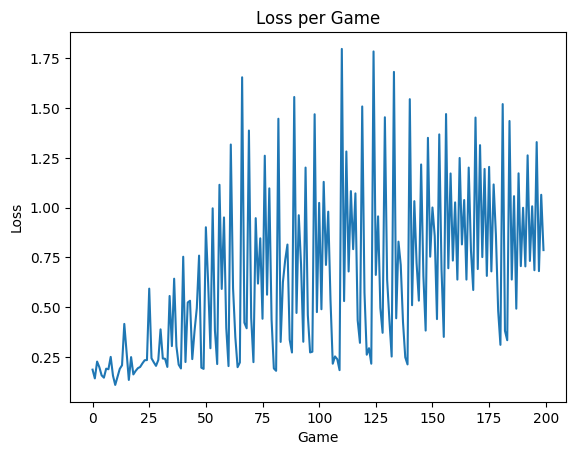

In [ ]:
import matplotlib.pyplot as plt
# Print and plot the losses
print(f"Average Loss: {sum(losses) / len(losses)}, Max Loss: {max(losses)}, Min Loss: {min(losses)}")
plt.plot(losses)
plt.xlabel('Game')
plt.ylabel('Loss')
plt.title('Loss per Game')
plt.show()

Play, Eval() - AddingGame_MCTS_Model2.pth

In [ ]:
# Initialize a list to store the results of each game
win_rates = []

from google.colab import drive
drive.mount('/content/drive')

# See the model playout 10 games using MCTS

# Load the model and optimizer
checkpoint = torch.load('/content/drive/My Drive/MCTS in Python/AddingGame_MCTS_Model2.pth')
network.load_state_dict(checkpoint['model_state_dict'])
mcts.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set the model to evaluation mode
network.eval()

# Simulate 10 games
num_games = 10

for i in range(num_games):
    print(f"Game {i + 1}:")

    # Initialize the game and the root node
    game_state = game.get_initial_state()
    root = Node(game_state, None)

    #Make sure that the MCTS and the root node persist throughout each game
    mcts = MCTS(network, root)

    while not game_state.is_terminal():
        # Perform MCTS simulations from the root
        for _ in range(num_games):
            leaf = mcts.selection(root)
            children = mcts.expansion(leaf)
            reward = mcts.simulation(random.choice(children))
            mcts.backpropagation(leaf, reward)

        # Choose the action that leads to the most visited child node
        action = mcts.choose_action(root)

        # Apply the action to get the next state
        game_state = game_state.make_move(action)

        print(f"Action taken: {action}")

    print(f"Final reward: {reward}")

    # Append the result of the game to the win_rates list
    # Assume a reward of 1 is a win, 0 is a draw, and -1 is a loss
    win_rates.append(reward)

# mcts.print_tree(mcts.root)

# Calculate the win rate
win_rate = win_rates.count(1) / num_games

# Print and plot the win rates
print(f"Win Rate: {win_rate}")
plt.plot(range(1, num_games + 1), win_rates)
plt.xlabel('Game')
plt.ylabel('Win Rate')
plt.title('Win Rate per Game')
plt.show()